In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
# !pip install --upgrade datasets

In [ ]:
# import datasets
# print(datasets.__version__)

In [2]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from transformers import pipeline
import torch
import time
import os
import pandas as pd
import numpy as np

In [11]:
from transformers import (
    GenerationConfig,
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    AutoModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    # pipeline,
    AutoConfig
)

### Paths

In [4]:
# Model
fine_tune_path = '/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM'
model_name = 'llama'
sub_model_name = 'llama_3_8b_instruct'
weights_path = f"{fine_tune_path}/{model_name}/{sub_model_name}"
eval_path = f"{fine_tune_path}/{model_name}/{sub_model_name}/eval_{sub_model_name}.csv"

In [5]:
# Dataset
mts_dialog_dir = "/content/drive/MyDrive/ClinicalNotesGen/Data/clinical_notes/data1_clinical_visit_note_summarization_corpus/data/mts-dialog"
mts_test_set_1_path = f"{mts_dialog_dir}/MTS_Dataset_Final_200_TestSet_1.csv"
mts_test_set_2_path = f"{mts_dialog_dir}/MTS_Dataset_Final_200_TestSet_2.csv"
mts_training_set_path = f"{mts_dialog_dir}/MTS_Dataset_TrainingSet.csv"
mts_val_set_path = f"{mts_dialog_dir}/MTS_Dataset_ValidationSet.csv"

aci_bench_dir = "/content/drive/MyDrive/ClinicalNotesGen/Data/clinical_notes/data1_clinical_visit_note_summarization_corpus/data/aci-bench"
challenge_data_dir = f"{aci_bench_dir}/challenge_data"
src_experiment_data_dir = f"{aci_bench_dir}/src_experiment_data"

### Dataset

In [6]:
mts_training_set_df = pd.read_csv(mts_training_set_path, index_col='ID')
mts_val_set_df = pd.read_csv(mts_val_set_path, index_col='ID')
mts_test_set_1_df = pd.read_csv(mts_test_set_1_path, index_col='ID')
mts_test_set_2_df = pd.read_csv(mts_test_set_2_path, index_col='ID')

In [7]:
# import all files in challenge_data_dir
challenge_data_files = os.listdir(challenge_data_dir)
challenge_data_dfs = {}
for file in challenge_data_files:
    challenge_data_dfs[file] = pd.read_csv(f"{challenge_data_dir}/{file}")

In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

### model, tokenizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
weights_path

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/llama/llama_3_8b_instruct'

In [12]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,  # bfloat16 for efficient memory usage
    # device_map="auto",
)

model.to(device)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [13]:
print_trainable_parameters(model)

trainable params: 8030261248 || all params: 8030261248 || trainable%: 100.0


In [14]:
print("Base model class:", type(model))

Base model class: <class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>


In [15]:
system = "You are a medical assistant trained to generate clinical notes from doctor-patient dialogues."
instruction = "Generate a short clinical summary based on this information, remember to generate short and concise summary, not a detailed SOAP note."

# Generate responses

In [ ]:
# Generation
generation_config = GenerationConfig(
    max_new_tokens=216,
    # min_length=64,
    num_beams=4,  # encourages diverse, complete outputs
    do_sample=False, # deterministic output
    early_stopping=True,    # helps finalize beam outputs when confident
    length_penalty=2.0      # higher = prefers longer outputs (default is 1.0)
)

In [40]:
def generate_response(dialogue, note):
    # prompt = f"""{dialogue}"""
    prompt = [
        {"role": "system", "content": f"{system}"},
        {"role": "user", "content": f"{dialogue}"},
        {"role": "assistant", "content": f"{instruction}"}
    ]

    input_tensor = tokenizer.apply_chat_template(
        prompt,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    input_token_length = input_tensor.shape[-1]
    print("Length of tokenized input:", input_token_length)

    # Define end-of-sequence tokens
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    generated_token_ids = model.generate(
        input_tensor,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    generated_token_length = len(generated_token_ids[0]) - input_token_length
    print(f"Length of generated output: {generated_token_length}")

    # Extract newly generated tokens (excluding input prompt)
    new_token_ids = generated_token_ids[0][input_token_length:]
    # response = generated_token_ids[0][input.shape[-1]:]

    # Decode tokens to text
    generated_text = tokenizer.decode(
        new_token_ids,
        skip_special_tokens=True
    )

    # Print results
    dash_line = '-'.join('' for x in range(100))
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'REFERENCE SUMMARY:\n{note}')
    print(dash_line)
    # print(f'TOKENIZED OUTPUT:\n{generated_token_ids}')
    # print(dash_line)
    print(f'BASE MODEL:\n{generated_text}')
    print(dash_line)

In [18]:
def check_length(text):
    prompt = f"""{text}"""

    # tokenize prompt
    input = tokenizer(
        prompt,
        return_tensors="pt",
    )
    print(f"Input token length: {input['input_ids'].shape[1]}")

### MCI-Dialog: short version

In [42]:
weights_path

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/llama/llama_3_8b_instruct'

In [44]:
generated_responses = []

for i in range(50):
    print(f"Processing sample {i}")
    dialogue = mts_training_set_df.iloc[i]['dialogue']
    note = mts_training_set_df.iloc[i]['section_text']

    prompt = [
        {"role": "system", "content": f"{system}"},
        {"role": "user", "content": f"{dialogue}"},
        {"role": "assistant", "content": f"{instruction}"}
    ]

    input_tensor = tokenizer.apply_chat_template(
        prompt,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    input_token_length = input_tensor.shape[-1]
    # print("Length of tokenized input:", input_token_length)

    # Define end-of-sequence tokens
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    generated_token_ids = model.generate(
        input_tensor,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    generated_token_length = len(generated_token_ids[0]) - input_token_length

    # Extract newly generated tokens (excluding input prompt)
    new_token_ids = generated_token_ids[0][input_token_length:]

    # Decode tokens to text
    generated_text = tokenizer.decode(
        new_token_ids,
        skip_special_tokens=True
    )

    generated_responses.append({
        'dialogue': dialogue,
        'reference_note': note,
        'model_output': generated_text
    })

results_df = pd.DataFrame(generated_responses)
# save result
results_df.to_csv(f"{weights_path}/first_10_generations_mci.csv", index=False)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

In [ ]:
check_length(results_df.iloc[0]["dialogue"])
check_length(results_df.iloc[0]["reference_note"])
check_length(results_df.iloc[0]["base_model_output"])
check_length(results_df.iloc[0]["fine_tuned_model_output"])

check_length(results_df.iloc[38]["dialogue"])
check_length(results_df.iloc[38]["reference_note"])
check_length(results_df.iloc[38]["base_model_output"])
check_length(results_df.iloc[38]["fine_tuned_model_output"])

Input token length: 174
Input token length: 102
Input token length: 22
Input token length: 34
Input token length: 662
Input token length: 199
Input token length: 22
Input token length: 2


In [ ]:
results_df

,dialogue,reference_note,base_model_output,fine_tuned_model_output
0,Doctor: What brings you back into the clinic t...,The patient is a 76-year-old white female who ...,A woman in her 70s has been seen by a doctor f...,"The patient is a white female, 70 years old, w..."
1,Doctor: How're you feeling today? \nPatient: ...,The patient is a 25-year-old right-handed Cauc...,"A patient has described to a doctor the ""worst...",
2,"Doctor: Hello, miss. What is the reason for yo...","This is a 22-year-old female, who presented to...",A woman in her 20s has been to the doctor beca...,
3,Doctor: Are you taking any over the counter me...,Prescribed medications were Salmeterol inhaler...,Patient: I have asthma and I have been prescri...,
4,"Doctor: Hi, how are you? \nPatient: I burned m...","Burn, right arm.","Patient: I burned my hand, so I can't use my r...",
5,Doctor: How's your asthma since you started us...,Asthma.,An exchange between an asthma sufferer and a d...,
6,"Doctor: Do you smoke? \nPatient: No, I quit be...","The patient denies high blood pressure, diabet...","Patient: I'm 20 years old, and I have a lower ...",
7,Doctor: Any know drug allergies? \nPatient: No.,No known drug allergies.,A patient has been admitted to hospital with a...,
8,"Doctor: Hi there, sir! How are you today? \nPa...",His mother died of complications from heart di...,Patient: I am a man in his late 50's and I hav...,
9,Doctor: Can you tell me about any diseases tha...,His brothers had prostate cancer. Father had ...,A patient has been diagnosed with cancer on bo...,


In [41]:
generate_response(mts_training_set_df.iloc[1]['dialogue'], mts_training_set_df.iloc[1]['section_text'])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Length of tokenized input: 422
Length of generated output: 99
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
[{'role': 'system', 'content': 'You are a medical assistant trained to generate clinical notes from doctor-patient dialogues.'}, {'role': 'user', 'content': "Doctor: How're you feeling today?  \nPatient: Terrible. I'm having the worst headache of my life. \nDoctor: I'm so sorry. Well you are only twenty five, so let's hope this is the last of the worst. Let's see how we can best help you. When did it start? \nPatient: Around eleven in the morning. \nDoctor: Today? \nPatient: Um no yesterday. July thirty first. \nDoctor: July thirty first O eight. Got it. Did it come on suddenly? \nPatient: Yeah. \nDoctor: Are you having any symptoms with it, such as blurry vision, light sensitivity, dizziness, lightheadedness, or nausea? \nPatient: I'm having blurry vision and lightheadedness.  I also can't seem to write well. It

In [24]:
generate_response(mts_training_set_df.iloc[30]['dialogue'], mts_training_set_df.iloc[30]['section_text'])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
[{'role': 'system', 'content': 'You are a medical assistant trained to generate clinical notes from doctor-patient dialogues.'}, {'role': 'user', 'content': 'Doctor: Hi, what brings you here today?\nPatient: I feel this lump on the upper side of my breast. \nDoctor: Both sides? \nPatient: No, only on the left side. \nDoctor: Do you feel it deep inside or on the outer side?\nPatient: Only on the outer side.'}, {'role': 'assistant', 'content': 'Generate a short clinical summary based on this information, remember to generate short and concise summary, not a detailed SOAP note.'}]
---------------------------------------------------------------------------------------------------
REFERENCE SUMMARY:
Suspicious calcifications upper outer quadrant, left breast.
---------------------------------------------------------------------------------------------------
BASE MODEL:
Here is a

In [ ]:
generate_response(mts_training_set_df.iloc[300]['dialogue'], mts_training_set_df.iloc[300]['section_text'])

Input token length: 512
Token length of note: 153
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Doctor: Good morning, can you tell me more about your son, ma'am. 
Guest_family: Sure, he's forty six, White, and he has Down syndrome.
Doctor: Great, thank you. Is he still having problems with his hypothyroidism and onychomycosis? 
Guest_family: Yes, that's correct doctor. 
Doctor: Has he remained complaint with his Lamisil? 
Guest_family: Yes, he's taken six weeks of it with no problems. 
Doctor: Good, so we'll do an A L T blood test today.
Guest_family: Why is that doctor? 
Doctor: Well, at his last appointment in April, he had an elevated T S H level. So, we should recheck that today. 
Guest_family: Yes, I remember that. 
Doctor: Has he been taking his Levothroid daily as well? 
Guest_family: Yes, he has, he doesn't like it, but I help him with it, and he eventually takes it. 
Doctor: Good, thanks for taking care of him

### Aci-bench: complete version

In [45]:
instruction_2 = "Generate a SOAP clinical note based on this information."

In [46]:
generated_responses_2 = []

for i in range(50):
    print(f"Processing sample {i}")
    dialogue = challenge_data_dfs['train.csv'].iloc[i]["dialogue"]
    note = challenge_data_dfs['train.csv'].iloc[i]["note"]

    prompt = [
        {"role": "system", "content": f"{system}"},
        {"role": "user", "content": f"{dialogue}"},
        {"role": "assistant", "content": f"{instruction}"}
    ]

    input_tensor = tokenizer.apply_chat_template(
        prompt,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    input_token_length = input_tensor.shape[-1]
    # print("Length of tokenized input:", input_token_length)

    # Define end-of-sequence tokens
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    generated_token_ids = model.generate(
        input_tensor,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    generated_token_length = len(generated_token_ids[0]) - input_token_length

    # Extract newly generated tokens (excluding input prompt)
    new_token_ids = generated_token_ids[0][input_token_length:]

    # Decode tokens to text
    generated_text = tokenizer.decode(
        new_token_ids,
        skip_special_tokens=True
    )

    generated_responses_2.append({
        'dialogue': dialogue,
        'reference_note': note,
        'model_output': generated_text
    })
results_df_2 = pd.DataFrame(generated_responses_2)
# save result
results_df_2.to_csv(f"{weights_path}/first_10_generations_aci.csv", index=False)
print(f"Saved to {weights_path}/first_10_generations_aci.csv")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 24


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 25


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 27


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 29


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 31


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 32


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 34


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 41


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 42


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 47


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Processing sample 49
Saved to /content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/llama/llama_3_8b_instruct/first_10_generations_aci.csv


In [ ]:
# Hãy tạo một bản tóm tắt lâm sàng ngắn gọn dựa trên thông tin này, lưu ý là tóm tắt phải ngắn gọn, súc tích, không phải là một bản SOAP chi tiết.

In [50]:
def generate_response_vietnamese(dialogue):
    # prompt = f"""{dialogue}"""
    system = "Bạn là một trợ lý y tế được đào tạo để tạo ghi chú lâm sàng từ các đoạn hội thoại giữa bác sĩ và bệnh nhân."
    instruction = "Hãy tạo một bản tóm tắt lâm sàng theo tiêu chuẩn SOAP dựa trên đoạn hội thoại sau."

    prompt = [
        {"role": "system", "content": f"{system}"},
        {"role": "user", "content": f"{dialogue}"},
        {"role": "assistant", "content": f"{instruction}"}
    ]

    input_tensor = tokenizer.apply_chat_template(
        prompt,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    input_token_length = input_tensor.shape[-1]
    print("Length of tokenized input:", input_token_length)

    # Define end-of-sequence tokens
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    generated_token_ids = model.generate(
        input_tensor,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    generated_token_length = len(generated_token_ids[0]) - input_token_length
    print(f"Length of generated output: {generated_token_length}")

    # Extract newly generated tokens (excluding input prompt)
    new_token_ids = generated_token_ids[0][input_token_length:]
    # response = generated_token_ids[0][input.shape[-1]:]

    # Decode tokens to text
    generated_text = tokenizer.decode(
        new_token_ids,
        skip_special_tokens=True
    )

    # Print results
    dash_line = '-'.join('' for x in range(100))
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    # print(f'TOKENIZED OUTPUT:\n{generated_token_ids}')
    # print(dash_line)
    print(f'BASE MODEL:\n{generated_text}')
    print(dash_line)

In [49]:
dialogue_vietnamese = """
Bác sĩ: Chào anh, hôm nay anh đến khám vì lý do gì?
Bệnh nhân: Dạ, mấy ngày nay tôi thấy đau bụng, đặc biệt là vùng bụng dưới bên phải. Cơn đau kéo dài và đôi khi dữ dội.
Bác sĩ: Cơn đau bắt đầu từ khi nào?
Bệnh nhân: Từ khoảng 3 ngày trước, ban đầu chỉ âm ỉ, nhưng hôm qua thì đau nhiều hơn.
Bác sĩ: Anh có bị sốt, buồn nôn hay nôn mửa không?
Bệnh nhân: Dạ có, hôm qua tôi bị sốt nhẹ, khoảng 38 độ, và buồn nôn nhưng chưa nôn.
Bác sĩ: Anh có đi tiêu bình thường không? Có tiêu chảy hay táo bón không?
Bệnh nhân: Tôi bị táo bón mấy ngày nay, đi tiêu rất khó khăn.
Bác sĩ: Anh có bị đau khi đi lại hoặc khi ấn vào vùng bụng không?
Bệnh nhân: Dạ có, khi đi lại thì cảm giác đau tăng lên, và khi chạm vào vùng bụng dưới bên phải thì rất đau.
Bác sĩ: Trước đây anh có tiền sử bị bệnh dạ dày hay bệnh đường ruột gì không?
Bệnh nhân: Dạ không, tôi không có tiền sử bệnh tiêu hóa.
Bác sĩ: Tôi sẽ khám lâm sàng cho anh và có thể chỉ định siêu âm bụng để kiểm tra thêm.
"""

In [51]:
generate_response_vietnamese(dialogue_vietnamese)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Length of tokenized input: 380
Length of generated output: 222
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
[{'role': 'system', 'content': 'Bạn là một trợ lý y tế được đào tạo để tạo ghi chú lâm sàng từ các đoạn hội thoại giữa bác sĩ và bệnh nhân.'}, {'role': 'user', 'content': '\nBác sĩ: Chào anh, hôm nay anh đến khám vì lý do gì?\nBệnh nhân: Dạ, mấy ngày nay tôi thấy đau bụng, đặc biệt là vùng bụng dưới bên phải. Cơn đau kéo dài và đôi khi dữ dội.\nBác sĩ: Cơn đau bắt đầu từ khi nào?\nBệnh nhân: Từ khoảng 3 ngày trước, ban đầu chỉ âm ỉ, nhưng hôm qua thì đau nhiều hơn.\nBác sĩ: Anh có bị sốt, buồn nôn hay nôn mửa không?\nBệnh nhân: Dạ có, hôm qua tôi bị sốt nhẹ, khoảng 38 độ, và buồn nôn nhưng chưa nôn.\nBác sĩ: Anh có đi tiêu bình thường không? Có tiêu chảy hay táo bón không?\nBệnh nhân: Tôi bị táo bón mấy ngày nay, đi tiêu rất khó khăn.\nBác sĩ: Anh có bị đau khi đi lại hoặc khi ấn vào vùng bụng không?\nBệnh nhân:

In [ ]:
# print("@note:")
# print(challenge_data_dfs['train.csv'].iloc[0]["note"])
# print('-' * 60)
# print("@dialogue:")
# print(challenge_data_dfs['train.csv'].iloc[0]["dialogue"])
generate_response(challenge_data_dfs['train.csv'].iloc[0]["dialogue"], challenge_data_dfs['train.csv'].iloc[0]["note"])

Input token length: 512
Token length of note: 856
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
[doctor] hi , martha . how are you ?
[patient] i'm doing okay . how are you ?
[doctor] i'm doing okay . so , i know the nurse told you about dax . i'd like to tell dax a little bit about you , okay ?
[patient] okay .
[doctor] martha is a 50-year-old female with a past medical history significant for congestive heart failure , depression and hypertension who presents for her annual exam . so , martha , it's been a year since i've seen you . how are you doing ?
[patient] i'm doing well . i've been traveling a lot recently since things have , have gotten a bit lighter . and i got my , my vaccine , so i feel safer about traveling . i've been doing a lot of hiking . uh , went to washington last weekend to hike in northern cascades, like around the mount baker area .
[doctor] nice . that's great . i'm glad to hear that you're stay

### Check loss

In [ ]:
weights_path

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/bart/bart_large_xsum_lora/trained_model_9'

In [ ]:
import json
import os

# Path to checkpoint directory
# checkpoint_dir = "dialogue-summary-training-1747929161"
checkpoints_path = f"{weights_path}/dialogue-summary-training-2025-05-30_09-37-43/checkpoint-740"
# Load trainer_state.json
trainer_state_path = os.path.join(checkpoints_path, "trainer_state.json")
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    # Print training and evaluation metrics
    for log in trainer_state["log_history"]:
        step = log.get("step", "N/A")
        train_loss = log.get("loss", "N/A")
        eval_loss = log.get("eval_loss", "N/A")
        print(f"Step {step}: Train Loss = {train_loss}, Eval Loss = {eval_loss}")
else:
    print("No trainer_state.json found. Check if training completed successfully.")

Step 4: Train Loss = 10.079, Eval Loss = N/A
Step 8: Train Loss = 9.9146, Eval Loss = N/A
Step 12: Train Loss = 10.0366, Eval Loss = N/A
Step 16: Train Loss = 10.1553, Eval Loss = N/A
Step 20: Train Loss = 9.9902, Eval Loss = N/A
Step 20: Train Loss = N/A, Eval Loss = 10.061128616333008
Step 24: Train Loss = 9.9698, Eval Loss = N/A
Step 28: Train Loss = 9.9753, Eval Loss = N/A
Step 32: Train Loss = 10.0274, Eval Loss = N/A
Step 36: Train Loss = 10.1, Eval Loss = N/A
Step 40: Train Loss = 10.0052, Eval Loss = N/A
Step 40: Train Loss = N/A, Eval Loss = 9.967955589294434
Step 44: Train Loss = 9.7723, Eval Loss = N/A
Step 48: Train Loss = 9.9439, Eval Loss = N/A
Step 52: Train Loss = 9.7452, Eval Loss = N/A
Step 56: Train Loss = 9.9953, Eval Loss = N/A
Step 60: Train Loss = 9.7523, Eval Loss = N/A
Step 60: Train Loss = N/A, Eval Loss = 9.666766166687012
Step 64: Train Loss = 9.6556, Eval Loss = N/A
Step 68: Train Loss = 9.7292, Eval Loss = N/A
Step 72: Train Loss = 9.4976, Eval Loss = N/A


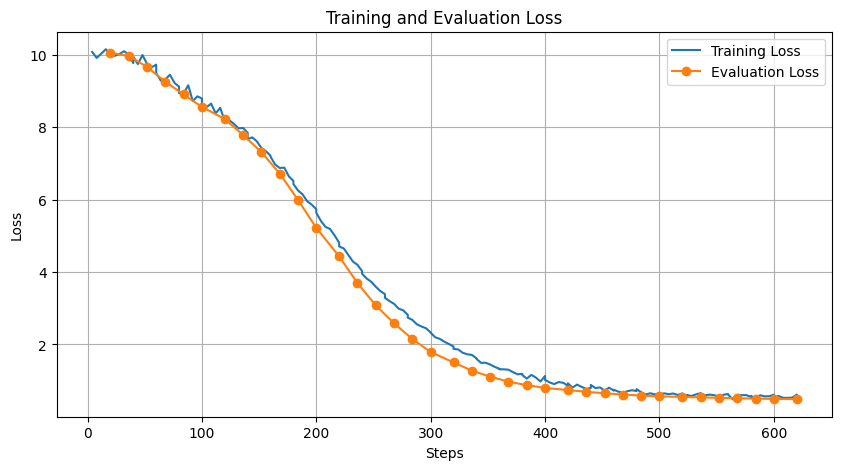

In [ ]:
import matplotlib.pyplot as plt

steps = []
train_losses = []
eval_losses = []
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    for log in trainer_state["log_history"]:
        step = log.get("step")
        if "loss" in log:
            steps.append(step)
            train_losses.append(log["loss"])
            eval_losses.append(None)
        if "eval_loss" in log:
            steps.append(step)
            eval_losses[-1] = log["eval_loss"]

    plt.figure(figsize=(10, 5))
    plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss")
    plt.plot([s for s, e in zip(steps, eval_losses) if e is not None],
             [e for e in eval_losses if e is not None],
             label="Evaluation Loss", marker="o")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trainer_state.json found.")

In [ ]:
# index = 30
# sample_dialogue = mts_training_set_df.iloc[index]['dialogue']
# sample_summary = mts_training_set_df.iloc[index]['section_text']

# # 2. create prompt
# prompt_idx_3 = f"""{sample_dialogue}"""

# batch = tokenizer(prompt_idx_3, return_tensors='pt')
# batch = {k: v.to(device) for k, v in batch.items()}

# with torch.cuda.amp.autocast():
#     output_tokens = base_model.generate(
#         **batch,
#         generation_config=generation_config
#     )

#     output_tokens_2 = ft_model.generate(
#         **batch,
#         generation_config=generation_config
#     )

# print("\nBase model:")
# print(tokenizer.decode(output_tokens[0], skip_special_tokens=True))
# print("\nFine-tuned model:")
# print(tokenizer.decode(output_tokens_2[0], skip_special_tokens=True))